### Toy problem 1: Formulate and solve flow optimization toy problem as MIP and QUBO

Obj Fcn: Minimize the total cost of flow <br> <br>
Constraints: <br>
&nbsp; 1. Flow conservation: The flow into each node equals the flow out of each node <br>
&nbsp; 2. At crossroads, the flow must take one of the two possible paths (binary constraint) <br><br>
<img src=toy1.png>

In [95]:
import pyomo.environ as pyo
import numpy as np

## MINLP Formulation

# Problem data
flow_network = {
    "f1": ("s1", "s2"),
    "f2": ("s2", "s3"),
    "f3": ("s3", "s4"),
    "f4": ("s3", "s5"),
    "f5": ("s4", "s6"),
    "f6": ("s5", "s6"),
    "f7": ("s6", "s7"),
}

flow_cost = {"f1": 1, "f2": 1, "f3": 3, "f4": 8, "f5": 4, "f6": 9, "f7": 1}

total_flow = 2

# penalty weights for binary constraints
Ky = 10
Kz = 4

# Model
model = pyo.ConcreteModel(doc="Flow Optimization Problem")

# Sets
model.nodes = pyo.Set(
    initialize=["s1", "s2", "s3", "s4", "s5", "s6", "s7"], doc="nodes"
)
model.edges = pyo.Set(initialize=flow_network.keys(), doc="edges")

# Decision Variables
# model.f = pyo.Var(model.edges, domain=pyo.NonNegativeReals, doc='flow on each edge')
model.f = pyo.Var(model.edges, domain=pyo.NonNegativeIntegers, doc="flow on each edge")
model.y = pyo.Var(domain=pyo.Binary, doc="binary decision variable for f3")
model.z = pyo.Var(domain=pyo.Binary, doc="binary decision variable for f4")

# Parameters
model.fcost = pyo.Param(
    model.edges, initialize=flow_cost, doc="cost of flow on each edge", mutable=True
)

# Objective Function (minimize cost)
model.totalcost = pyo.Objective(
    expr=sum(model.f[e] * model.fcost[e] for e in model.edges)
    + Ky * model.y
    + Kz * model.z,
    sense=pyo.minimize,
)


# Constraints


# Disjunction Constraint
def disjunction_rule(model):
    return model.y + model.z == 1


model.disjunction = pyo.Constraint(rule=disjunction_rule, doc="disjunction constraint")


# Flow Conservation Constraints
def flow_conservation_rule(model, node):
    inflow = sum(model.f[edge] for edge in model.edges if flow_network[edge][1] == node)
    outflow = sum(
        model.f[edge] for edge in model.edges if flow_network[edge][0] == node
    )
    if node == "s1":
        return outflow == total_flow  # source node
    elif node == "s7":
        return inflow == total_flow  # sink node
    else:
        return inflow == outflow  # intermediate nodes


model.flow_conservation = pyo.Constraint(
    model.nodes, rule=flow_conservation_rule, doc="flow conservation constraints"
)

model.xrd1 = pyo.Constraint(expr=model.f["f3"] * model.z <= 0, doc="linking z with f3")
model.xrd2 = pyo.Constraint(expr=model.f["f4"] * model.y <= 0, doc="linking y with f4")

# Solve the model using a solver
solver = pyo.SolverFactory("gurobi", solver_io="python")
results = solver.solve(model, tee=True)

model.pprint()
print(results)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 8 rows, 9 columns and 16 nonzeros
Model fingerprint: 0xd58443e3
Model has 2 quadratic constraints
Variable types: 0 continuous, 9 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 7 rows and 7 columns
Presolve time: 0.01s
Presolved: 3 rows, 3 columns, 6 nonzeros
Variable types: 0 continuous, 3 integer (1 binary)
Found heuristic solution: objective 44.0000000

Root relaxation: objective 3.000000e+01, 0 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

In [96]:
# Reset obj function, constraints and solve again
# Delete nonlinear constraints xrd1 and xrd2

del model.xrd1, model.xrd2
model.xrd1 = pyo.Constraint(
    expr=model.y + model.f["f4"] / total_flow == 1, doc="f3 or f4 constraint1"
)
model.xrd2 = pyo.Constraint(
    expr=model.z + model.f["f3"] / total_flow == 1, doc="f3 or f4 constraint2"
)

# Solve the model using a solver
solver = pyo.SolverFactory("gurobi", solver_io="python")
results = solver.solve(model, tee=True)

model.pprint()
print(results)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 10 rows, 9 columns and 20 nonzeros
Model fingerprint: 0xcb863100
Variable types: 0 continuous, 9 integer (2 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 10 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 30 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+01, best bound 3.000000000000e+01, gap 0.0000%
Flow Optimization Problem

    2 Set Declarations
        edges : edges
            Size=1, 

In [97]:
# Delete constraints and variables
del model.totalcost
del model.disjunction

# Additional parameter for penalty weights
P = 11

# Moving constraints to the objective
# disjunction constraint
model.totalcost = pyo.Objective(
    expr=sum(model.f[e] * model.fcost[e] for e in model.edges)
    + Ky * model.y
    + Kz * model.z
    + P * (1 - (model.y + model.z)) ** 2,
    sense=pyo.minimize,
)


# Solve the model using a solver
solver = pyo.SolverFactory("gurobi", solver_io="python")
results = solver.solve(model, tee=True)

model.pprint()
print(results)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 9 rows, 9 columns and 18 nonzeros
Model fingerprint: 0xe76ae390
Model has 3 quadratic objective terms
Variable types: 0 continuous, 9 integer (2 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e+01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 9 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 30 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+01, best bound 3.000000000000e+01, gap 0.0000%
Flow Optimization Prob

Notes: <br>
The optimal objective function value and f values are the same; however, the binary variables y and z are both set to 0. <br>
 - The objective function value is the same because the penalty weights (P) and (Ky), for disjunction violation and y=1 respectively, are the same value at 10. 

How to enforce the disjunction when the constraint is moved to the objective? 
 - increase the penalty weight (P) to larger than (Ky).

In [98]:
# Delete constraints and variables
del model.totalcost, model.flow_conservation

# Moving constraints to the objective
# disjunction constraint and flow conservation constraints
model.totalcost = pyo.Objective(
    expr=sum(model.f[e] * model.fcost[e] for e in model.edges)
    + Ky * model.y
    + Kz * model.z
    + P * ((model.y + model.z) - 1) ** 2
    + P
    * (
        (model.f["f2"] - (model.f["f3"] + model.f["f4"])) ** 2
        + ((model.f["f5"] + model.f["f6"]) - model.f["f7"]) ** 2
        + (model.f["f1"] - model.f["f2"]) ** 2
        + (model.f["f3"] - model.f["f5"]) ** 2
        + (model.f["f4"] - model.f["f6"]) ** 2
        + (total_flow - model.f["f7"]) ** 2
        + (total_flow - model.f["f1"]) ** 2
    ),
    sense=pyo.minimize,
)


# Solve the model using a solver
solver = pyo.SolverFactory("gurobi", solver_io="python")
results = solver.solve(model, tee=True)

model.pprint()
print(results)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2 rows, 9 columns and 4 nonzeros
Model fingerprint: 0xa561d425
Model has 19 quadratic objective terms
Variable types: 0 continuous, 9 integer (2 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [1e+00, 4e+01]
  QObjective range [2e+01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 113.0000000
Presolve removed 2 rows and 2 columns
Presolve time: 0.00s
Presolved: 0 rows, 7 columns, 0 nonzeros
Presolved model has 16 quadratic objective terms
Variable types: 0 continuous, 7 integer (2 binary)
Found heuristic solution: objective 71.0000000

Root relaxation: objective 2.901653e+01, 7 iterations, 0.00 seconds (0.00 work units)

    No

In [99]:
# Reset obj function, constraints and solve again
# Delete nonlinear constraints xrd1 and xrd2

del model.totalcost, model.xrd1, model.xrd2

model.totalcost = pyo.Objective(
    expr=sum(model.f[e] * model.fcost[e] for e in model.edges)
    + Ky * model.y
    + Kz * model.z
    + P * ((model.y + model.z) - 1) ** 2
    + P
    * (
        (model.f["f2"] - (model.f["f3"] + model.f["f4"])) ** 2
        + ((model.f["f5"] + model.f["f6"]) - model.f["f7"]) ** 2
        + (model.f["f1"] - model.f["f2"]) ** 2
        + (model.f["f3"] - model.f["f5"]) ** 2
        + (model.f["f4"] - model.f["f6"]) ** 2
        + (total_flow - model.f["f7"]) ** 2
        + (total_flow - model.f["f1"]) ** 2
        + (model.y + model.f["f4"] / total_flow - 1) ** 2
        + (model.z + model.f["f3"] / total_flow - 1) ** 2
    ),
    sense=pyo.minimize,
)

# Solve the model using a solver
solver = pyo.SolverFactory("gurobi", solver_io="python")
results = solver.solve(model, tee=True)

model.pprint()
print(results)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 0 rows, 9 columns and 0 nonzeros
Model fingerprint: 0x3fc1b175
Model has 21 quadratic objective terms
Variable types: 0 continuous, 9 integer (2 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+00, 4e+01]
  QObjective range [2e+01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 121.0000000
Found heuristic solution: objective 113.0000000
Presolve time: 0.00s
Presolved: 0 rows, 9 columns, 0 nonzeros
Presolved model has 21 quadratic objective terms
Variable types: 0 continuous, 9 integer (2 binary)
Found heuristic solution: objective 61.0000000

Root relaxation: objective 2.685522e+01, 8 iterations, 0.00 seconds (0.00 work unit

## Simplified Flow Network 
Leveraging some of the equalities in the problem, the flow network can be simplified <br>
> 7 --> 4 nodes (f1 = f2; f3 = f5; f4 = f6) <br>
> 7 --> 4 edges (f1 = f2; f3 = f5; f4 = f6)

Additionally, the edge can be written as binary variables to denote flow or no flow on that edge, and the total_flow can be used as a weight to binary variable: 
> total flow on edge i = total_flow * fi where fi = 1 if flows through the edge, fi = 0 if no flow.

<br>

<img src=toy1_simple.png>


In [100]:
import pyomo.environ as pyo
import numpy as np

## MIP Formulation

# Problem data
flow_network = {
    "f1": ("s1", "s2"),
    "f2": ("s2", "s3"),
    "f3": ("s2", "s3"),
    "f4": ("s3", "s4"),
}

flow_cost = {"f1": 2, "f2": 7, "f3": 17, "f4": 1}

total_flow = 2

# penalty weights for binary constraints
K2 = 10
K3 = 4

# Model
model = pyo.ConcreteModel(doc="Flow Optimization Problem")

# Sets
model.nodes = pyo.Set(initialize=["s1", "s2", "s3", "s4"], doc="nodes")
model.edges = pyo.Set(initialize=flow_network.keys(), doc="edges")

# Decision Variables
model.f = pyo.Var(
    model.edges, domain=pyo.Binary, doc="flow binary decision on each edge"
)

# Parameters
model.fcost = pyo.Param(
    model.edges, initialize=flow_cost, doc="cost of flow on each edge", mutable=True
)

# Objective Function (minimize cost)
model.totalcost = pyo.Objective(
    expr=sum(model.f[e] * model.fcost[e] for e in model.edges) * total_flow
    + K2 * model.f["f2"]
    + K3 * model.f["f3"],
    sense=pyo.minimize,
)


# Constraints
# Disjunction Constraint
def disjunction_rule(model):
    return model.f["f2"] + model.f["f3"] == 1
model.disjunction = pyo.Constraint(rule=disjunction_rule, doc="disjunction constraint")


# Flow Conservation Constraints
def flow_conservation_rule(model, node):
    inflow = sum(model.f[edge] for edge in model.edges if flow_network[edge][1] == node)
    outflow = sum(
        model.f[edge] for edge in model.edges if flow_network[edge][0] == node
    )
    if node == "s1":
        return outflow * total_flow == total_flow  # source node
    elif node == "s4":
        return inflow * total_flow == total_flow  # sink node
    else:
        return inflow == outflow  # intermediate nodes
model.flow_conservation = pyo.Constraint(
    model.nodes, rule=flow_conservation_rule, doc="flow conservation constraints"
)

# Solve the model using a solver
solver = pyo.SolverFactory("gurobi", solver_io="python")
results = solver.solve(model, tee=True)

model.pprint()
print(results)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 5 rows, 4 columns and 10 nonzeros
Model fingerprint: 0xa203806a
Variable types: 0 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 5 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 30 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+01, best bound 3.000000000000e+01, gap 0.0000%
Flow Optimization Problem

    2 Set Declarations
        edges : edges
            Size=1, In

In [101]:
# Delete disjunction constraint and obj function
del model.totalcost, model.disjunction

# Additional parameter for penalty weight
P = 11

# Moving disjunction constraint to obj function
model.totalcost = pyo.Objective(
    expr=sum(model.f[e] * model.fcost[e] for e in model.edges) * total_flow
    + K2 * model.f["f2"]
    + K3 * model.f["f3"]
    + P * ((model.f["f2"] + model.f["f3"] - 1) ** 2),
    sense=pyo.minimize,
)

# Solve
solver = pyo.SolverFactory("gurobi", solver_io="python")
results = solver.solve(model, tee=True)

model.pprint()
print(results)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4 rows, 4 columns and 8 nonzeros
Model fingerprint: 0x1484a577
Model has 3 quadratic objective terms
Variable types: 0 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e+00, 2e+01]
  QObjective range [2e+01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve removed 4 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 30 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+01, best bound 3.000000000000e+01, gap 0.0000%
Flow Optimization Probl

In [102]:
# Delete flow conservation constraints and reset obj function
del model.totalcost, model.flow_conservation

model.totalcost = pyo.Objective(
    expr=sum(model.f[e] * model.fcost[e] for e in model.edges) * total_flow
    + K2 * model.f["f2"]
    + K3 * model.f["f3"]
    + P
    * (
        (model.f["f2"] + model.f["f3"] - 1) ** 2
        + (model.f["f1"] - 1) ** 2
        + (model.f["f4"] - 1) ** 2
        + (model.f["f2"] + model.f["f3"] - model.f["f4"]) ** 2
        + (model.f["f2"] + model.f["f3"] - model.f["f1"]) ** 2
    ),
    sense=pyo.minimize,
)

# Solve the model using a solver
solver = pyo.SolverFactory("gurobi", solver_io="python")
results = solver.solve(model, tee=True)

model.pprint()
print(results)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 0 rows, 4 columns and 0 nonzeros
Model fingerprint: 0x0654bdf0
Model has 9 quadratic objective terms
Variable types: 0 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [2e+00, 2e+01]
  QObjective range [4e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 33.0000000
Found heuristic solution: objective 30.0000000
Presolve removed 0 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 30 33 

Optimal solution found (tolerance 1.00e-04)
Best

In [103]:
import pyomo.environ as pyo
import numpy as np

# Problem data
flow_network = {
    "f1": ("s1", "s2"),
    "f2": ("s2", "s3"),
    "f3": ("s2", "s3"),
    "f4": ("s3", "s4"),
}

flow_cost = {"f1": 2, "f2": 7, "f3": 17, "f4": 1}

total_flow = 2

# penalty weights for binary constraints
K2 = 10
K3 = 4

# penalty weight for augmented terms
P = 11 

# Model
model = pyo.ConcreteModel(doc="Flow Optimization Problem")

# Sets
model.nodes = pyo.Set(initialize=["s1", "s2", "s3", "s4"], doc="nodes")
model.edges = pyo.Set(initialize=flow_network.keys(), doc="edges")

# Decision Variables
model.f = pyo.Var(
    model.edges, domain=pyo.Binary, doc="flow binary decision on each edge"
)

# Parameters
model.fcost = pyo.Param(
    model.edges, initialize=flow_cost, doc="cost of flow on each edge", mutable=True
)

# Objective Function (minimize cost)
model.totalcost = pyo.Objective(
    expr=sum(model.f[e] * model.fcost[e] for e in model.edges) * total_flow
    + K2 * model.f["f2"]
    + K3 * model.f["f3"]
    + P
    * (
        (model.f["f2"] + model.f["f3"] - 1) ** 2 # disjunction constraint
        + (model.f["f1"] - 1) ** 2          # flow conservation constraints
        + (model.f["f4"] - 1) ** 2
        + (model.f["f2"] + model.f["f3"] - model.f["f4"]) ** 2
        + (model.f["f2"] + model.f["f3"] - model.f["f1"]) ** 2
    ),
    sense=pyo.minimize,
)

# Solve the model using a solver
solver = pyo.SolverFactory("gurobi", solver_io="python")
results = solver.solve(model, tee=True)

model.pprint()
print(results)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 0 rows, 4 columns and 0 nonzeros
Model fingerprint: 0x0654bdf0
Model has 9 quadratic objective terms
Variable types: 0 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [2e+00, 2e+01]
  QObjective range [4e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 33.0000000
Found heuristic solution: objective 30.0000000
Presolve removed 0 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 30 33 

Optimal solution found (tolerance 1.00e-04)
Best

## QUBO Formulation 

#### Problem statement <br>
We define a QUBO as the following optimization problem: <br>
$$
\min_{x \in \{0,1 \}^n} \sum_{(ij) \in E(G)} Q_{ij}x_i x_j + \sum_{i \in V(G)} Q_{ii}x_i + c_Q = \min_{x \in \{0,1 \}^n}  x^\top Q x + c_Q
$$ 

where we optimize over binary variables $x\in\{0,1\}^n$, on a constrained graph $G(V,E)$ defined by an adjacency matrix $Q$. We also include an arbitrary offset  $c_Q$.
<br>

source = https://colab.research.google.com/github/SECQUOIA/QUBONotebooks/blob/main/notebooks_py/2-QUBO_python.ipynb#scrollTo=_XlB7ddYZn3-

From the MIP formulation above, we have the following problem: 

$$
\min_{f \in \{0,1 \}^4} \sum_{i} F c_i f_i + K_2 f_2 + K_3 f_3 \\
s.t.  
f_2 + f_3 = 1 \\  
f_1 = 1 \\
f_4 = 1 \\ 
f_1 = f_2 + f_3 \\ 
f_4 = f_2 + f_3 \\ 
$$ 

where we optimize over binary variables $f\in\{0,1\}^4$; with parameters $F = 2$ = total flow, $c_i$ = cost at edge $i$, $K_2 = 10$ = penalty cost of taking edge 2, and $K_3 = 4$ = penalty cost of taking edge 3

After moving the constraints to the objective function, the problem can be rewritten: 

$$
\min_{f \in \{0,1 \}^4} \sum_{i} F c_i f_i + K_2 f_2 + K_3 f_3 + \rho [(f_2 + f_3 - 1)^2 + (f_1 - 1)^2 + (f_4 - 1)^2 + (f_1 - (f_2 + f_3))^2 + (f_4 - (f_2 + f_3))^2]
$$ 

where we chose an arbitrary penalty weight, $\rho = 11$.  

Writing the original problem into standard form: 

$$
\begin{array}{rl}
    \displaystyle%
    \min_{\mathbf{x}} &\mathbf{c}' \mathbf{x} \\
    \textrm{s.t.}     & \mathbf{A}\mathbf{x} = \mathbf{b} \\
    ~                 & \mathbf{x} \in \{0,1 \}^{4}
\end{array}
$$

with matrices: 
$$
\mathbf{A} = 
\begin{bmatrix}
0 &  1 &  1 & 0\\
1 & -1 & -1 & 0\\ 
1 &  0 &  0 & 0\\
0 &  0 &  0 & 1\\
0 & -1 & -1 & 1
\end{bmatrix}
,
\mathbf{b}=
\begin{bmatrix}
1\\
0\\ 
1\\
1\\
0
\end{bmatrix} 
,
\mathbf{c}= 2
\begin{bmatrix}
2\\
7 + 10/2\\ 
17 + 4/2\\
1
\end{bmatrix} 
=
\begin{bmatrix}
4\\
24\\ 
38\\
2
\end{bmatrix} 
$$

In [104]:
A = np.array([[0, 1, 1, 0],
            [1, -1, -1, 0],
            [1, 0, 0, 0],
            [0, 0, 0, 1],
            [0, -1, -1, 1]])
b = np.array([1, 0, 1, 1, 0])
c = np.array([4, 24, 38, 2])

rho = 11  # penalty weight for augmented terms 

Q = rho * np.matmul(A.T, A) 
Q += np.diag(c) 
Q -= rho*2*np.diag(np.matmul(b.T, A))
Beta = rho*np.matmul(b.T,b)

print(Q)
print(Beta)

[[  4 -11 -11   0]
 [-11  35  33 -11]
 [-11  33  49 -11]
 [  0 -11 -11   2]]
33


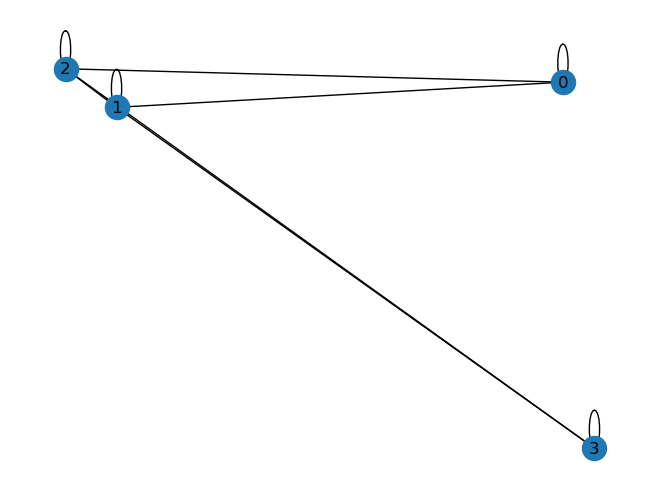

In [105]:
import networkx as nx   
import dimod 
import neal
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

G = nx.from_numpy_array(Q)
nx.draw(G, with_labels=True)

In [106]:
model = dimod.BinaryQuadraticModel.from_qubo(Q, offset=Beta)
print(model)

BinaryQuadraticModel({0: 4.0, 1: 35.0, 2: 49.0, 3: 2.0}, {(1, 0): -22.0, (2, 0): -22.0, (2, 1): 66.0, (3, 1): -22.0, (3, 2): -22.0}, 33.0, 'BINARY')


In [107]:
exactSampler = dimod.reference.samplers.ExactSolver()
exactSamples = exactSampler.sample(model)

In [108]:
print(exactSamples)

    0  1  2  3 energy num_oc.
13  1  1  0  1   30.0       1
0   0  0  0  0   33.0       1
15  0  0  0  1   35.0       1
1   1  0  0  0   37.0       1
14  1  0  0  1   39.0       1
9   1  0  1  1   44.0       1
12  0  1  0  1   48.0       1
2   1  1  0  0   50.0       1
8   0  0  1  1   62.0       1
6   1  0  1  0   64.0       1
3   0  1  0  0   68.0       1
7   0  0  1  0   82.0       1
10  1  1  1  1  101.0       1
11  0  1  1  1  141.0       1
5   1  1  1  0  143.0       1
4   0  1  1  0  183.0       1
['BINARY', 16 rows, 16 samples, 4 variables]


In [109]:
def plot_enumerate(results, title=None):

    plt.figure()

    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by='energy')]
    
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    plt.bar(samples,energies)
    plt.xticks(rotation=90)
    plt.ylabel('Energy')
    plt.title(str(title))
    print("minimum energy:", min(energies))

def plot_samples(results, title=None):
    plt.figure()
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    counts = Counter(samples)
    total = len(samples)
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None)

    plt.xticks(rotation=80)
    plt.ylabel('Probabilities')
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))


def plot_energies(results, title=None, skip=1):
    # skip parameter given to avoid putting all xlabels
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    ax = df.plot(kind='bar', legend=None)

    plt.xlabel('Energy')
    plt.ylabel('Probabilities')
    # Plot only a subset of xlabels (every skip steps)
    ax.set_xticklabels([t if not i%skip else "" for i,t in enumerate(ax.get_xticklabels())])
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))

minimum energy: 30.0


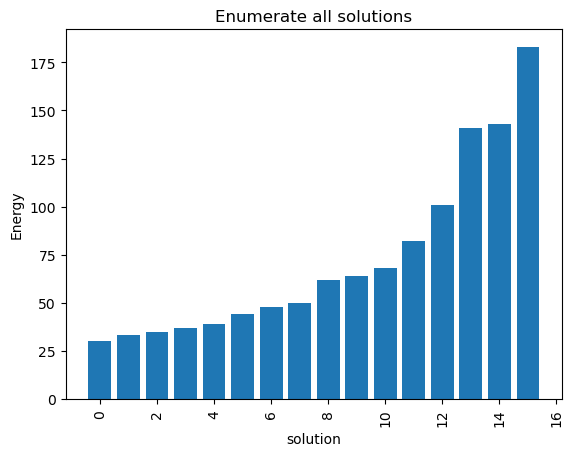

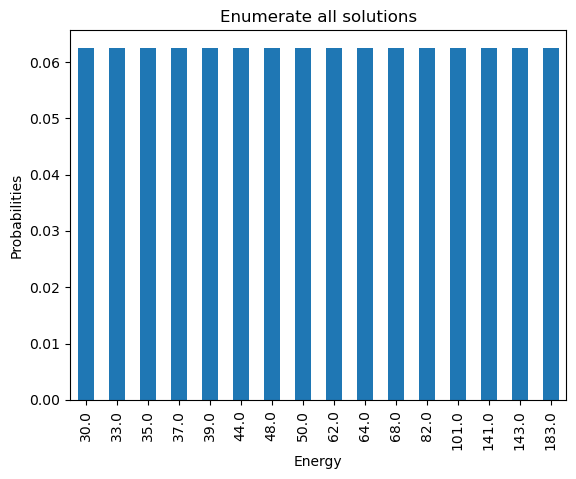

minimum energy: 30.0


In [110]:
plot_enumerate(exactSamples, title='Enumerate all solutions')
plot_energies(exactSamples, title='Enumerate all solutions')